In [1]:
import os
import numpy as np
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torchvision import models
import torchvision.transforms as transforms
from misc_functions import preprocess_image, recreate_image, save_image
import matplotlib.pyplot as plt
import matplotlib


%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 15, 7

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Number of GPUs available: ',torch.cuda.device_count())
device

Number of GPUs available:  1


device(type='cuda', index=0)

In [3]:
class Data():
    
    def __init__(self):
        
        self.train_set = datasets.CIFAR10(
        root = './data',
        train = True,
        download = True,
        transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])
        )

        self.test_set = datasets.CIFAR10(
        root= './data',
        train= False,
        download = True,
        transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])
        )
        
    def get_data(self):
        return [self.train_set, self.test_set]

In [4]:
data = Data()
train, test = data.get_data()
train_loader = torch.utils.data.DataLoader(train, batch_size= 256, shuffle= True)
test_loader = torch.utils.data.DataLoader(test, batch_size= 10000, shuffle= True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
images, labels = next(iter(train_loader))
images.shape

torch.Size([256, 3, 224, 224])

In [9]:
model = models.vgg16_bn(pretrained= True)
in_feat = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_features= in_feat, out_features= 10)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [19]:
count = 0
for name, params in model.named_parameters():
    count += 1

    if count < 55:
        params.requires_grad = False


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
def train(epoch, losses, net):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        losses.append(loss.item())
        _, predicted = outputs.max(1)  #this returns values and labels
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print(batch_idx, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
def test(net, test_losses ):
    
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            
            test_losses.append(loss.item())
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            print('Loss: %.3f | Acc: %.3f%%'
                  % (test_loss, 100.*correct/len(test_loader.dataset)))

In [25]:
epochs = 5
losses = []
test_losses = []
for epoch in range(epochs):
    train(epoch, losses, model)


Epoch: 0
0 196 Loss: 2.413 | Acc: 5.078% (13/256)
1 196 Loss: 2.383 | Acc: 7.031% (36/512)
2 196 Loss: 2.348 | Acc: 9.375% (72/768)
3 196 Loss: 2.304 | Acc: 13.086% (134/1024)
4 196 Loss: 2.243 | Acc: 18.281% (234/1280)
5 196 Loss: 2.183 | Acc: 22.656% (348/1536)
6 196 Loss: 2.128 | Acc: 25.614% (459/1792)
7 196 Loss: 2.072 | Acc: 28.369% (581/2048)
8 196 Loss: 2.017 | Acc: 31.424% (724/2304)
9 196 Loss: 1.955 | Acc: 34.297% (878/2560)
10 196 Loss: 1.901 | Acc: 36.364% (1024/2816)
11 196 Loss: 1.853 | Acc: 38.118% (1171/3072)
12 196 Loss: 1.803 | Acc: 40.234% (1339/3328)
13 196 Loss: 1.751 | Acc: 42.243% (1514/3584)
14 196 Loss: 1.717 | Acc: 43.490% (1670/3840)
15 196 Loss: 1.673 | Acc: 45.044% (1845/4096)
16 196 Loss: 1.631 | Acc: 46.507% (2024/4352)
17 196 Loss: 1.593 | Acc: 47.721% (2199/4608)
18 196 Loss: 1.562 | Acc: 48.828% (2375/4864)
19 196 Loss: 1.530 | Acc: 49.883% (2554/5120)
20 196 Loss: 1.502 | Acc: 50.688% (2725/5376)
21 196 Loss: 1.479 | Acc: 51.296% (2889/5632)
22 196 

172 196 Loss: 0.846 | Acc: 70.931% (31414/44288)
173 196 Loss: 0.845 | Acc: 70.948% (31603/44544)
174 196 Loss: 0.845 | Acc: 70.955% (31788/44800)
175 196 Loss: 0.844 | Acc: 70.963% (31973/45056)
176 196 Loss: 0.844 | Acc: 70.955% (32151/45312)
177 196 Loss: 0.843 | Acc: 70.986% (32347/45568)
178 196 Loss: 0.842 | Acc: 70.996% (32533/45824)
179 196 Loss: 0.842 | Acc: 70.974% (32705/46080)
180 196 Loss: 0.842 | Acc: 70.982% (32890/46336)
181 196 Loss: 0.841 | Acc: 70.999% (33080/46592)
182 196 Loss: 0.841 | Acc: 71.030% (33276/46848)
183 196 Loss: 0.840 | Acc: 71.041% (33463/47104)
184 196 Loss: 0.840 | Acc: 71.041% (33645/47360)
185 196 Loss: 0.838 | Acc: 71.081% (33846/47616)
186 196 Loss: 0.838 | Acc: 71.077% (34026/47872)
187 196 Loss: 0.837 | Acc: 71.102% (34220/48128)
188 196 Loss: 0.837 | Acc: 71.125% (34413/48384)
189 196 Loss: 0.836 | Acc: 71.137% (34601/48640)
190 196 Loss: 0.836 | Acc: 71.139% (34784/48896)
191 196 Loss: 0.835 | Acc: 71.147% (34970/49152)
192 196 Loss: 0.835 

148 196 Loss: 0.668 | Acc: 76.694% (29254/38144)
149 196 Loss: 0.667 | Acc: 76.716% (29459/38400)
150 196 Loss: 0.667 | Acc: 76.710% (29653/38656)
151 196 Loss: 0.667 | Acc: 76.714% (29851/38912)
152 196 Loss: 0.667 | Acc: 76.708% (30045/39168)
153 196 Loss: 0.667 | Acc: 76.712% (30243/39424)
154 196 Loss: 0.667 | Acc: 76.724% (30444/39680)
155 196 Loss: 0.668 | Acc: 76.693% (30628/39936)
156 196 Loss: 0.667 | Acc: 76.712% (30832/40192)
157 196 Loss: 0.666 | Acc: 76.723% (31033/40448)
158 196 Loss: 0.666 | Acc: 76.700% (31220/40704)
159 196 Loss: 0.666 | Acc: 76.694% (31414/40960)
160 196 Loss: 0.666 | Acc: 76.696% (31611/41216)
161 196 Loss: 0.666 | Acc: 76.698% (31808/41472)
162 196 Loss: 0.666 | Acc: 76.699% (32005/41728)
163 196 Loss: 0.665 | Acc: 76.741% (32219/41984)
164 196 Loss: 0.665 | Acc: 76.750% (32419/42240)
165 196 Loss: 0.665 | Acc: 76.774% (32626/42496)
166 196 Loss: 0.664 | Acc: 76.787% (32828/42752)
167 196 Loss: 0.664 | Acc: 76.809% (33034/43008)
168 196 Loss: 0.663 

124 196 Loss: 0.624 | Acc: 78.216% (25029/32000)
125 196 Loss: 0.623 | Acc: 78.224% (25232/32256)
126 196 Loss: 0.623 | Acc: 78.217% (25430/32512)
127 196 Loss: 0.623 | Acc: 78.192% (25622/32768)
128 196 Loss: 0.623 | Acc: 78.231% (25835/33024)
129 196 Loss: 0.623 | Acc: 78.230% (26035/33280)
130 196 Loss: 0.623 | Acc: 78.241% (26239/33536)
131 196 Loss: 0.623 | Acc: 78.226% (26434/33792)
132 196 Loss: 0.622 | Acc: 78.254% (26644/34048)
133 196 Loss: 0.622 | Acc: 78.259% (26846/34304)
134 196 Loss: 0.622 | Acc: 78.249% (27043/34560)
135 196 Loss: 0.622 | Acc: 78.266% (27249/34816)
136 196 Loss: 0.621 | Acc: 78.285% (27456/35072)
137 196 Loss: 0.621 | Acc: 78.300% (27662/35328)
138 196 Loss: 0.621 | Acc: 78.316% (27868/35584)
139 196 Loss: 0.621 | Acc: 78.323% (28071/35840)
140 196 Loss: 0.621 | Acc: 78.336% (28276/36096)
141 196 Loss: 0.621 | Acc: 78.334% (28476/36352)
142 196 Loss: 0.620 | Acc: 78.354% (28684/36608)
143 196 Loss: 0.620 | Acc: 78.350% (28883/36864)
144 196 Loss: 0.621 

100 196 Loss: 0.585 | Acc: 79.583% (20577/25856)
101 196 Loss: 0.586 | Acc: 79.538% (20769/26112)
102 196 Loss: 0.586 | Acc: 79.524% (20969/26368)
103 196 Loss: 0.586 | Acc: 79.534% (21175/26624)
104 196 Loss: 0.586 | Acc: 79.531% (21378/26880)
105 196 Loss: 0.585 | Acc: 79.588% (21597/27136)
106 196 Loss: 0.586 | Acc: 79.531% (21785/27392)
107 196 Loss: 0.585 | Acc: 79.586% (22004/27648)
108 196 Loss: 0.586 | Acc: 79.573% (22204/27904)
109 196 Loss: 0.585 | Acc: 79.602% (22416/28160)
110 196 Loss: 0.585 | Acc: 79.585% (22615/28416)
111 196 Loss: 0.586 | Acc: 79.586% (22819/28672)
112 196 Loss: 0.586 | Acc: 79.570% (23018/28928)
113 196 Loss: 0.585 | Acc: 79.612% (23234/29184)
114 196 Loss: 0.585 | Acc: 79.633% (23444/29440)
115 196 Loss: 0.585 | Acc: 79.637% (23649/29696)
116 196 Loss: 0.584 | Acc: 79.667% (23862/29952)
117 196 Loss: 0.584 | Acc: 79.658% (24063/30208)
118 196 Loss: 0.584 | Acc: 79.645% (24263/30464)
119 196 Loss: 0.585 | Acc: 79.603% (24454/30720)
120 196 Loss: 0.585 

75 196 Loss: 0.552 | Acc: 80.623% (15686/19456)
76 196 Loss: 0.551 | Acc: 80.636% (15895/19712)
77 196 Loss: 0.550 | Acc: 80.664% (16107/19968)
78 196 Loss: 0.551 | Acc: 80.657% (16312/20224)
79 196 Loss: 0.551 | Acc: 80.615% (16510/20480)
80 196 Loss: 0.551 | Acc: 80.599% (16713/20736)
81 196 Loss: 0.551 | Acc: 80.545% (16908/20992)
82 196 Loss: 0.551 | Acc: 80.586% (17123/21248)
83 196 Loss: 0.552 | Acc: 80.576% (17327/21504)
84 196 Loss: 0.552 | Acc: 80.561% (17530/21760)
85 196 Loss: 0.552 | Acc: 80.532% (17730/22016)
86 196 Loss: 0.552 | Acc: 80.523% (17934/22272)
87 196 Loss: 0.551 | Acc: 80.571% (18151/22528)
88 196 Loss: 0.550 | Acc: 80.578% (18359/22784)
89 196 Loss: 0.550 | Acc: 80.608% (18572/23040)
90 196 Loss: 0.549 | Acc: 80.636% (18785/23296)
91 196 Loss: 0.549 | Acc: 80.677% (19001/23552)
92 196 Loss: 0.549 | Acc: 80.662% (19204/23808)
93 196 Loss: 0.549 | Acc: 80.647% (19407/24064)
94 196 Loss: 0.549 | Acc: 80.646% (19613/24320)
95 196 Loss: 0.549 | Acc: 80.668% (19825

In [27]:
losses

[2.4133658409118652,
 2.353222131729126,
 2.2784433364868164,
 2.171703338623047,
 2.000088691711426,
 1.8789926767349243,
 1.7969523668289185,
 1.680960774421692,
 1.5750030279159546,
 1.3986485004425049,
 1.3654052019119263,
 1.3206865787506104,
 1.206394910812378,
 1.0717005729675293,
 1.236668586730957,
 1.0152697563171387,
 0.9584745168685913,
 0.9577629566192627,
 0.9895340800285339,
 0.9224869012832642,
 0.9514044523239136,
 0.9994108080863953,
 0.9076970815658569,
 0.9001109600067139,
 0.8896563053131104,
 0.9452534317970276,
 0.8091635704040527,
 0.9229411482810974,
 0.9165022373199463,
 0.7174444198608398,
 0.8527745008468628,
 0.9716043472290039,
 0.9098724126815796,
 0.8573554158210754,
 0.7867193222045898,
 0.9777892827987671,
 0.8584585189819336,
 0.8364958763122559,
 0.8267377018928528,
 0.7696470022201538,
 0.9216687679290771,
 0.7391424179077148,
 0.7758863568305969,
 0.7641139030456543,
 0.8833498954772949,
 0.7606205344200134,
 0.949346661567688,
 0.8383579254150391,

Text(0.5,0,'Epochs')

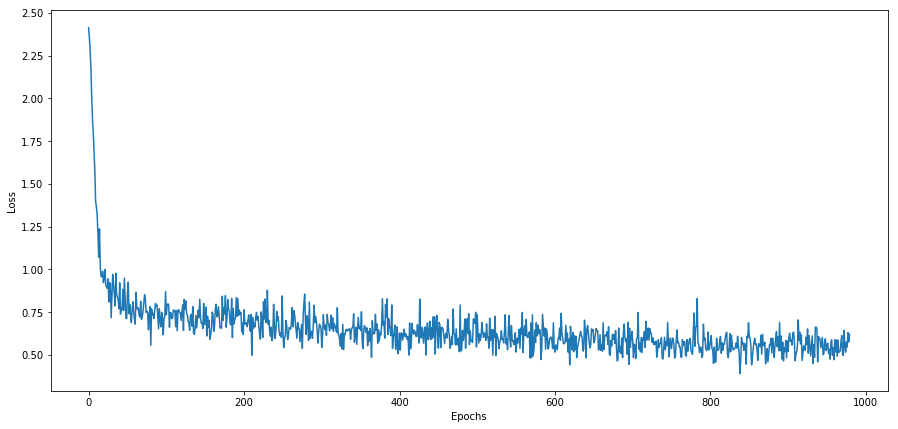

In [28]:

plt.plot(losses)

plt.ylabel('Loss')
plt.xlabel('Epochs')

In [36]:
## Model parameters

# print("Our model: \n\n", model, '\n')
# print("The state dict keys: \n\n", model.state_dict().keys())

# save the model 
checkpoint = {'input_size': 224,
              'output_size': 10,
              'epoch': epoch +1,
              'optimizer': optimizer.state_dict(),
              'scheduler': exp_lr_scheduler.state_dict(),
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoints/checkpoint.pth')

In [ ]:
# load the weights



In [37]:
class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Create the folder to export images if not exists
        if not os.path.exists('generated'):
            os.makedirs('generated')

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            print(grad_out[0, self.selected_filter].shape)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        #random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        random_image = images[3].permute(2,1,0)
        # Process image and return variable
        print("random image ", random_image.shape)
        processed_image = preprocess_image(random_image, False)
        print("processed images size", processed_image.shape)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 145):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
            if i % 5 == 0:
                im_path = 'generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)

In [38]:
cnn_layer = 17
filter_pos = 5
# Fully connected layer is not needed
pretrained_model = models.vgg16(pretrained=True).features
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()

random image  torch.Size([224, 224, 3])
processed images size torch.Size([1, 3, 224, 224])
torch.Size([28, 28])
Iteration: 1 Loss: -0.90
torch.Size([28, 28])
Iteration: 2 Loss: -0.33
torch.Size([28, 28])
Iteration: 3 Loss: -8.54
torch.Size([28, 28])
Iteration: 4 Loss: -17.80
torch.Size([28, 28])
Iteration: 5 Loss: -26.36
torch.Size([28, 28])
Iteration: 6 Loss: -34.41
torch.Size([28, 28])
Iteration: 7 Loss: -41.93
torch.Size([28, 28])
Iteration: 8 Loss: -49.07
torch.Size([28, 28])
Iteration: 9 Loss: -55.91
torch.Size([28, 28])
Iteration: 10 Loss: -62.52
torch.Size([28, 28])
Iteration: 11 Loss: -68.93
torch.Size([28, 28])
Iteration: 12 Loss: -75.14
torch.Size([28, 28])
Iteration: 13 Loss: -81.21
torch.Size([28, 28])
Iteration: 14 Loss: -87.22
torch.Size([28, 28])
Iteration: 15 Loss: -93.11
torch.Size([28, 28])
Iteration: 16 Loss: -98.89
torch.Size([28, 28])
Iteration: 17 Loss: -104.57
torch.Size([28, 28])
Iteration: 18 Loss: -110.19
torch.Size([28, 28])
Iteration: 19 Loss: -115.75
torch.

In [43]:
images[0].shape

torch.Size([3, 224, 224])

dim:  torch.Size([224, 224])


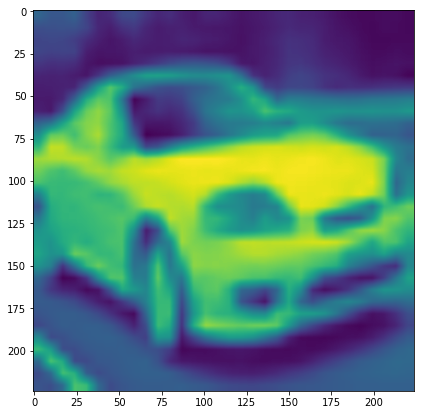

In [52]:


print("dim: ", images[3][0].shape)
fig = plt.figure()
plt.imshow(images[5][0], interpolation= 'bicubic')


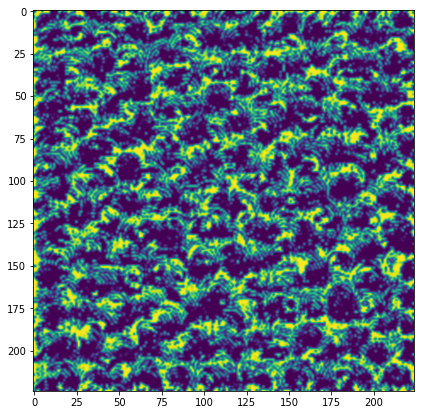

In [46]:

fig = plt.figure()
plt.imshow(layer_vis.created_image[:,:,0], interpolation= 'bicubic')



In [ ]:
pretrained_model[17]
images[1].permute(2,1,0).shape